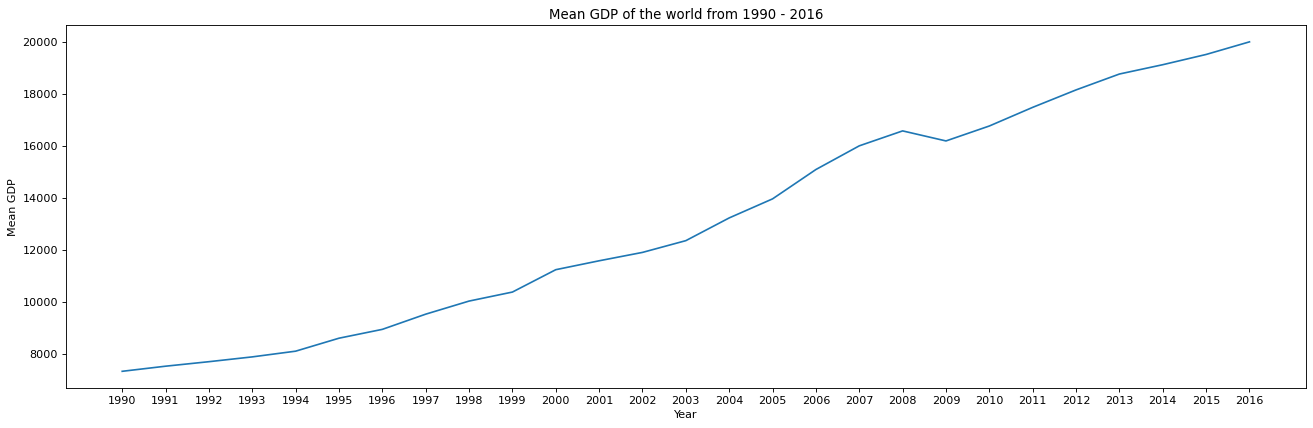

The lowest GDP in the world in 1990: 424.823989 in Ethiopia
The highest GDP in the world in 1990: 72906.52012 in United Arab Emirates
The lowest GDP in the world in 2016: 743.9035976 in Burundi
The highest GDP in the world in 2016: 123573.6308 in Qatar


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


dfGDP = pd.read_csv("/Users/jordi/Documents/School 2021 - 2022/Data Mining/Datasets/GDP.csv")
dfGDP.drop(['2017','2018','2019'], axis=1, inplace=True)

GDP_means = []
GDP_extremes = []
GDP_extremes_country = []

years = dfGDP.columns.tolist()
del years[:2]

# Mean GDP every year
for year in years:
    year_list = dfGDP[str(year)].tolist()
    year_list = [x for x in year_list if str(x) != 'nan']
    year_mean = sum(year_list) / len(year_list)
    GDP_means.append(year_mean)
    
# Min and Max GDP for 1990 and 2016
for year in [years[0], years[-1]]:
    year_list = dfGDP[str(year)].tolist()
    year_min = min(year_list)
    year_max = max(year_list)
    GDP_extremes.append((year, year_min, "min"))
    GDP_extremes.append((year, year_max, "max"))
    
figure(figsize=(20, 6), dpi=80)
plt.plot(years, GDP_means)
plt.xlabel('Year')
plt.ylabel('Mean GDP')
plt.title('Mean GDP of the world from 1990 - 2016')
plt.show()

dfExtremes = dfGDP[['Country ', years[0], years[-1]]]
# Find which countries the extreme values belong to
for gdp in GDP_extremes:
    year, gdp_value, extreme = gdp
    result = dfExtremes[dfExtremes[year] == gdp_value]
    country = (result['Country '].to_string())[1:]
    country = ''.join([i for i in country if not i.isdigit()])
    country = country.strip()
    GDP_extremes_country.append((year, gdp_value, extreme, country))
    
print("The lowest GDP in the world in " + GDP_extremes_country[0][0] + ": " + str(GDP_extremes_country[0][1]) + " in " + GDP_extremes_country[0][3])
print("The highest GDP in the world in " + GDP_extremes_country[1][0] + ": " + str(GDP_extremes_country[1][1]) + " in " + GDP_extremes_country[1][3])
print("The lowest GDP in the world in " + GDP_extremes_country[2][0] + ": " + str(GDP_extremes_country[2][1]) + " in " + GDP_extremes_country[2][3])
print("The highest GDP in the world in " + GDP_extremes_country[3][0] + ": " + str(GDP_extremes_country[3][1]) + " in " + GDP_extremes_country[3][3])
